<a href="https://colab.research.google.com/github/mgupta325/tensorflow_classification/blob/master/text%20_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

In [3]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2020-05-05 14:03:44--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 64.233.189.102, 64.233.189.113, 64.233.189.100, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3vd33tg8ukpg071skjcuiljjvntodjli/1588687425000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2020-05-05 14:03:47--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3vd33tg8ukpg071skjcuiljjvntodjli/1588687425000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|108.17

In [0]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [5]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


In [0]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 21s 14ms/step - loss: 5.9814 - accuracy: 0.0469
Epoch 2/100
1480/1480 [==============================] - 21s 14ms/step - loss: 5.6775 - accuracy: 0.0516
Epoch 3/100
1480/1480 [==============================] - 21s 14ms/step - loss: 5.4914 - accuracy: 0.0659
Epoch 4/100
1480/1480 [==============================] - 21s 14ms/step - loss: 5.3273 - accuracy: 0.0873
Epoch 5/100
1480/1480 [==============================] - 21s 14ms/step - loss: 5.1860 - accuracy: 0.1044
Epoch 6/100
1480/1480 [==============================] - 21s 14ms/step - loss: 5.0499 - accuracy: 0.1200
Epoch 7/100
1480/1480 [==============================] - 21s 14ms/step - loss: 4.9301 - accuracy: 0.1340
Epoch 8/100
1480/1480 [==============================] - 21s 14ms/step - loss: 4.8215 - accuracy: 0.1474
Epoch 9/100
1480/1480 [==============================] - 21s 14ms/step - loss: 4.7132 - accuracy: 0.1612
Epoch 10/100
1480/1480 [==============================]

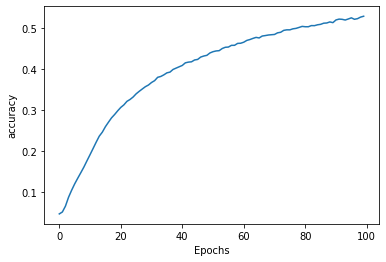

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [9]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills me to you know i dont want to be want to be good in the moon light of india your eyes do see over you now but you fail the tiger flow true jump and seem me can begun oh oh much to stay so cold too shame beautiful scream door mam mam mam word harm human sea more limit limit gold holding tall working falling sea ma ma ma colors woman it is sailing blue ball thats in hearts blue over round playing music see blue nancy hit easily same posses write figure limit melody melody melody melody melody


In [22]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

51


In [23]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

im feeling chills me nothing sure to know it late at night alive is all alone were the sound damn roll livin for you believe me song were young when rescue and pull for me now to know it well get it now or leave her pie out into the slam the door yeah were door yeah oh lordy nowhere moonlight needed for holding bright many sorry needed in warm she jive warm fernando sometimes come nancy seems to believe this all must well scream cause lead such all over what you say went through what went crazy alone from your crazy song
